In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import metrics
import warnings

import matplotlib.pyplot as plt

from datetime import datetime as dt

warnings.filterwarnings('ignore')


### 赛题背景

**围网**

围网捕鱼就是专门为了捕捞在海面附近活动的鱼群所准备的，字面意思理解，就是用一张大网把鱼群围起来。为了完成这一系列作业，围网渔船需要有灵活的船身，这样方便快速的兜圈子。


**拖网**

拖网捕捞可以从字面意义上去解读，就是一艘船拖着渔网前进，把海里的鱼“兜”进去，然后收网。拖网是高能耗作业。


**刺网**

将长带形的网列敷设于水域中，使鱼刺入网目或被网衣缠络后加以捕捞的作业方式。网列由若干矩形网具连接而成，其长度可根据水域条件、渔船大小等因素确定，短则几十米，最长可达数千米。刺网渔具种类繁多，广泛应用于各国的捕捞业。

### 数据特征

#### 导入数据

In [2]:
train = pd.read_hdf('C:/Users/f3107/Desktop/hy_data/train_descending_deltatime.h5')
train['datetime'] = pd.to_datetime(train['datetime'],train['delta_time'], format='%m%d %H:%M:%S')

In [3]:
train.head()

,ship_ID,x,y,speed_v,direction,datetime,type,delta_time
413,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:09:28,拖网,00:00:00
412,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:18:30,拖网,00:09:02
411,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:28:32,拖网,00:19:04
410,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:38:32,拖网,00:29:04
409,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:48:30,拖网,00:39:02


#### 时间间隔

In [4]:
train['delta_time'] = train['delta_time'].dt.total_seconds().astype('int')

In [5]:
train.head()

,ship_ID,x,y,speed_v,direction,datetime,type,delta_time
413,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:09:28,拖网,0
412,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:18:30,拖网,542
411,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:28:32,拖网,1144
410,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:38:32,拖网,1744
409,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:48:30,拖网,2342


In [6]:
t = train[train['ship_ID']==41]

In [17]:
t['delta_direction'] = 0
t['delta_direction'] = abs(t['direction'].diff())

In [19]:
t['new_delta_direction'] = 180-abs(t['delta_direction']-180)

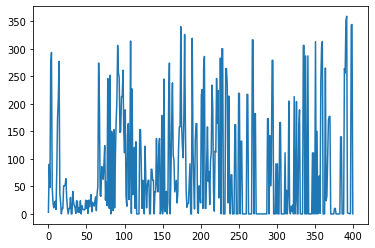

In [18]:
plt.plot(t['delta_direction'])

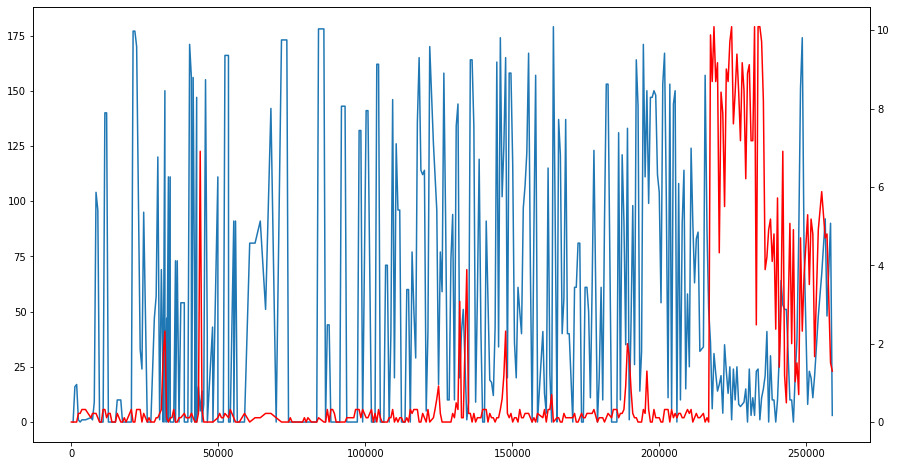

In [32]:
plt.figure(figsize=(15,8))
plt.plot(t['delta_time'], t['new_delta_direction'])

plt.twinx()

plt.plot(t['delta_time'], t['speed_v'], color='red')

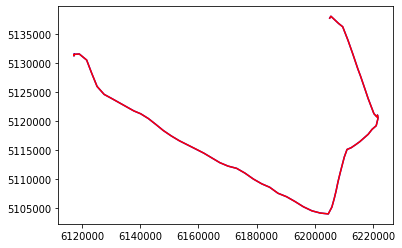

In [50]:
tt = t[t['delta_time'] >215000]
plt.plot(t.x,t.y,color='blue')
plt.plot(tt.x,tt.y,color='red')

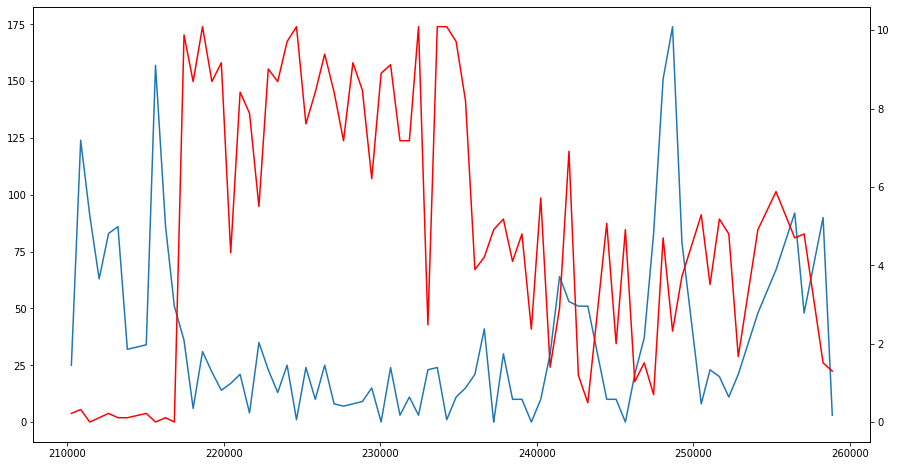

In [49]:
plt.figure(figsize=(15,8))
plt.plot(tt['delta_time'], tt['new_delta_direction'])

plt.twinx()

plt.plot(tt['delta_time'], tt['speed_v'], color='red')

In [39]:
t

,ship_ID,x,y,speed_v,direction,datetime,type,delta_time,delta_direction,new_delta_direction
401,41,6.117349e+06,5.131461e+06,0.00,0,1900-11-07 12:00:50,拖网,0,NaN,NaN
400,41,6.117350e+06,5.131570e+06,0.00,0,1900-11-07 12:10:35,拖网,585,0.0,0.0
399,41,6.117350e+06,5.131570e+06,0.00,344,1900-11-07 12:20:46,拖网,1196,344.0,16.0
398,41,6.117350e+06,5.131570e+06,0.00,1,1900-11-07 12:30:54,拖网,1804,343.0,17.0
397,41,6.117350e+06,5.131570e+06,0.22,0,1900-11-07 12:40:38,拖网,2388,1.0,1.0
396,41,6.117350e+06,5.131570e+06,0.22,0,1900-11-07 12:50:35,拖网,2985,0.0,0.0
395,41,6.117350e+06,5.131570e+06,0.32,1,1900-11-07 13:00:41,拖网,3591,1.0,1.0
394,41,6.117350e+06,5.131570e+06,0.32,2,1900-11-07 13:20:50,拖网,4800,1.0,1.0
393,41,6.117350e+06,5.131570e+06,0.11,0,1900-11-07 13:51:43,拖网,6653,2.0,2.0
392,41,6.117350e+06,5.131570e+06,0.22,359,1900-11-07 14:00:45,拖网,7195,359.0,1.0


### 单个船的状态
每个ship确定是只有一种状态

In [11]:
len(train.groupby(['ship','type']).count())

7000

### x,y坐标

x,y元数据做过变形

#### 均值散点图

在学习器中，最大值和最小值的重要性是最高的。

In [80]:
#坐标散点图，mean，max，min分布类似
def GPS_scatter(train_xy_label,attribute):
    fig, ax = plt.subplots(figsize = (15,12))
    plt.title(attribute)

    t = train_xy_label[train_xy_label['type'] == '拖网']    
    ax.scatter(t.x, t.y, label = 'tuo', marker = '^')

    t = train_xy_label[train_xy_label['type'] == '围网']    
    ax.scatter(t.x, t.y, label = 'wei', marker = 'o')

    t = train_xy_label[train_xy_label['type'] == '刺网']    
    ax.scatter(t.x, t.y, label = 'ci', marker = '+')

    ax.legend()

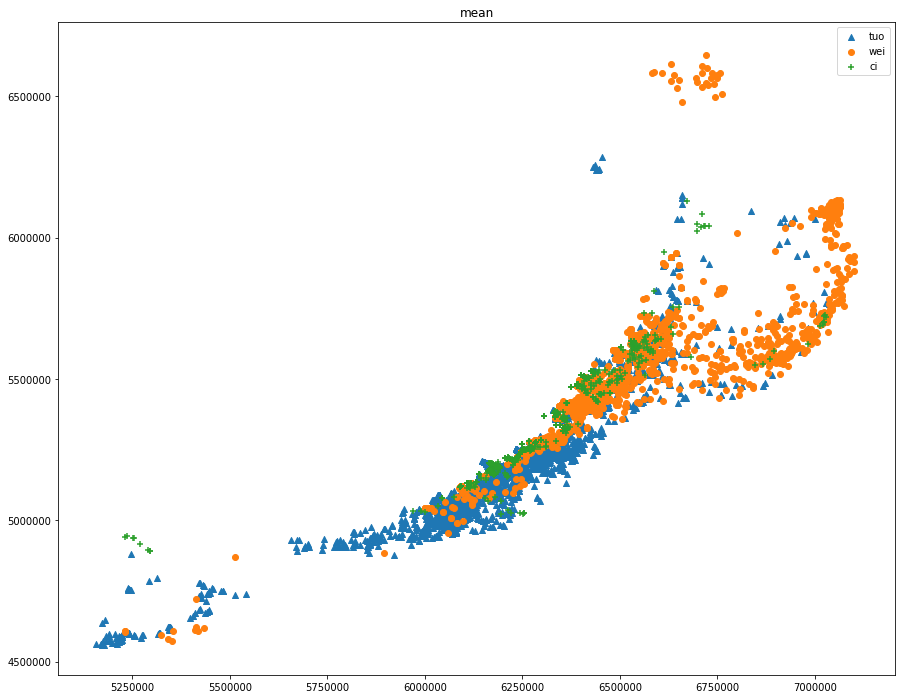

In [83]:
train_xy_mean = train[['x','y']].groupby(train['ship']).mean()
train_label = train.loc[:,['ship','type']].drop_duplicates('ship')

train_xy_label = pd.merge(train_xy_mean,train_label,on = 'ship')

GPS_scatter(train_xy_label,'mean')

#### 坐标密度直方图

目前重要性最高的特征

In [ ]:
#坐标密度直方图
def GPS_distplot(train_xy_label,attribute,z):
    fig, ax = plt.subplots(figsize = (15,8))
    plt.title(attribute)
    
    if z == 'x':

        t = train_xy_label[train_xy_label['type'] == '拖网'] 
        sns.distplot(t.x, bins = 200, kde = False, label = 'tuo')

        t = train_xy_label[train_xy_label['type'] == '围网'] 
        sns.distplot(t.x, bins = 200, kde = False, label = 'wei')

        t = train_xy_label[train_xy_label['type'] == '刺网'] 
        sns.distplot(t.x, bins = 200, kde = False, label = 'ci')
        
    if z == 'y':
        
        t = train_xy_label[train_xy_label['type'] == '拖网'] 
        sns.distplot(t.y, bins = 200, kde = False, label = 'tuo')

        t = train_xy_label[train_xy_label['type'] == '围网'] 
        sns.distplot(t.y, bins = 200, kde = False, label = 'wei')

        t = train_xy_label[train_xy_label['type'] == '刺网'] 
        sns.distplot(t.y, bins = 200, kde = False, label = 'ci')

    ax.legend()

In [86]:
train_xy_max = train[['x','y']].groupby(train['ship']).max()
train_label = train.loc[:,['ship','type']].drop_duplicates('ship')

train_xy_label = pd.merge(train_xy_mean,train_label,on = 'ship')

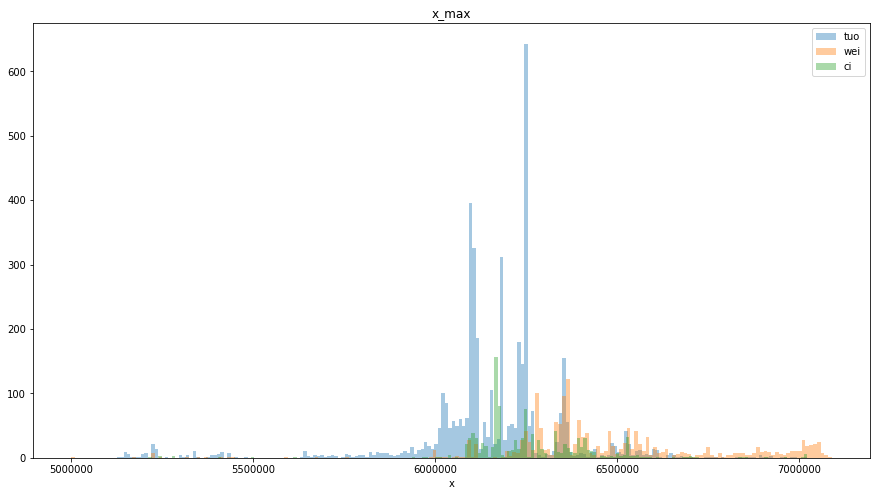

In [106]:
GPS_distplot(train_xy_label,'x_max','x')

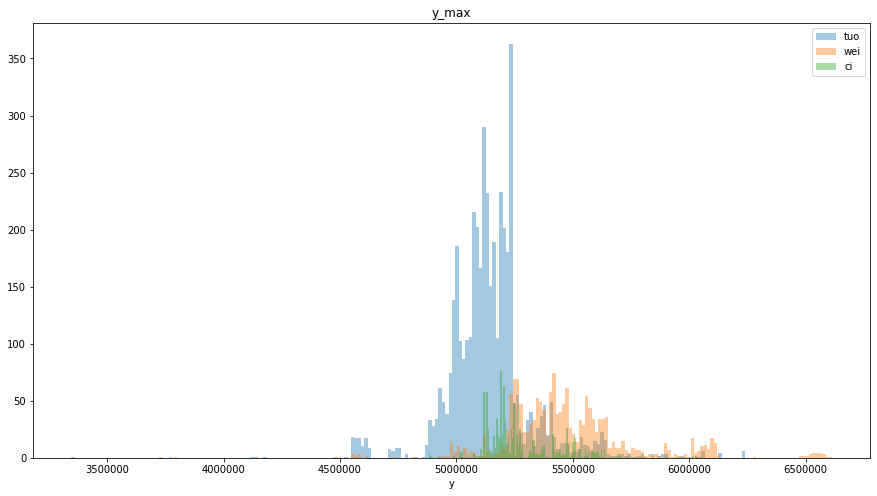

In [107]:
GPS_distplot(train_xy_label,'y_max','y')

#### 坐标轨迹

很多信号漂移严重

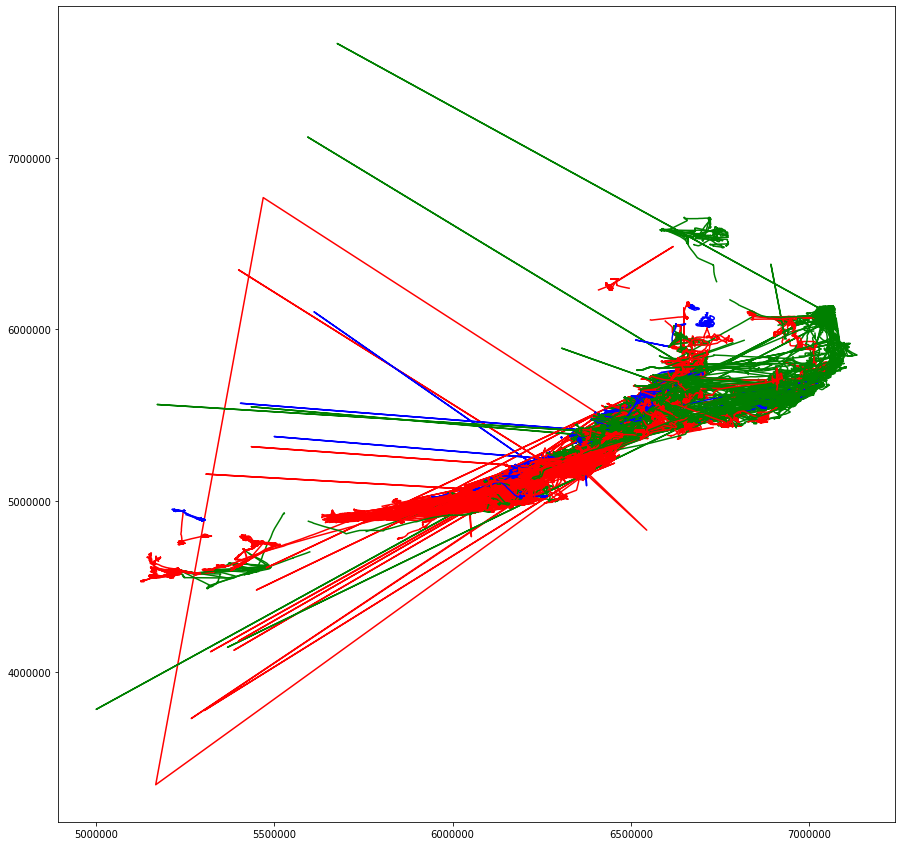

In [120]:
fig, ax = plt.subplots(figsize = (15,15))

for i in range(7000):
    t = train[train['ship'] == i]
    if t.loc[0,'type'] == '拖网':   
        plt.plot(t.x, t.y,color = 'red',label = 'tuo')
    if t.loc[0,'type'] == '围网':
        plt.plot(t.x, t.y,color = 'green',label = 'wei')
    if t.loc[0,'type'] == '刺网':
        plt.plot(t.x, t.y,color = 'blue',label = 'ci')

ax.legend()

#### 坐标范围剔除

In [68]:
train_xy = train[['x','y']].groupby(train['ship_ID']).agg(['max','min'])

In [107]:
x_range = pd.Series(train_xy['x']['max']-train_xy['x']['min'],name='x_max_x_min')
y_range = pd.Series(train_xy['y']['max']-train_xy['y']['min'],name='y_max_y_min')

train_label = train.drop_duplicates('ship_ID')

train_range = pd.merge(x_range,y_range,on='ship_ID')
train_range = pd.merge(train_range,train_label[['ship_ID','type']],on='ship_ID')

In [155]:
range100 = list(train_range['ship_ID'][(train_range['x_max_x_min']<100) & (train_range['y_max_y_min']<100)])

In [156]:
import shutil

for i in range100:
    
    shutil.copy(f'C:/Users/f3107/Desktop/hy_data/figs/total/[{i}].png', f'C:/Users/f3107/Desktop/hy_data/figs/100/[{i}].png') 

In [157]:
len(range100)

204

(0, 1000)

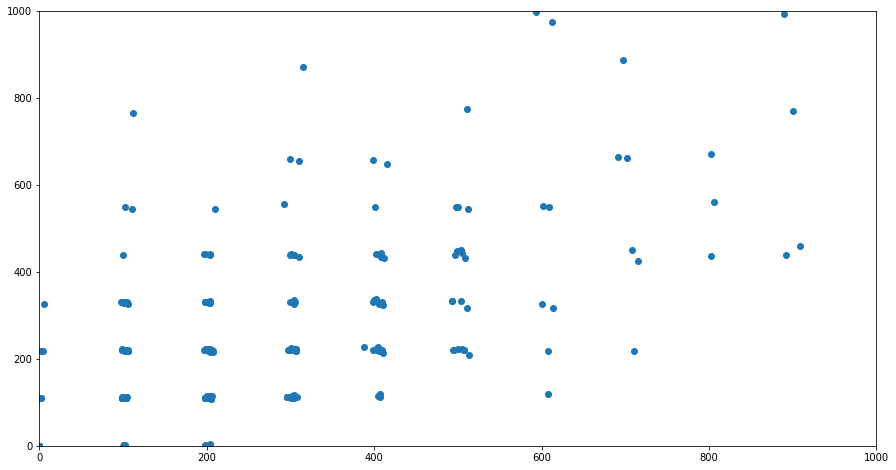

In [129]:
train_ci = train_range[train_range['type'] == '刺网']
plt.figure(figsize=(15,8))
plt.scatter(train_ci.x_max_x_min, train_ci.y_max_y_min)
plt.xlim(0,1000)
plt.ylim(0,1000)

In [148]:
train_ci[(train_ci['x_max_x_min']<100) & (train_ci['y_max_y_min']<100)]

,ship_ID,x_max_x_min,y_max_y_min,type
131,131,0.0,0.0,刺网
283,283,0.0,0.0,刺网
746,746,0.0,0.0,刺网
846,846,0.0,0.0,刺网
1019,1019,0.0,0.0,刺网
1140,1140,0.0,0.0,刺网
1452,1452,0.0,0.0,刺网
1514,1514,0.0,0.0,刺网
1612,1612,0.0,0.0,刺网
1708,1708,0.0,0.0,刺网


(0, 1000)

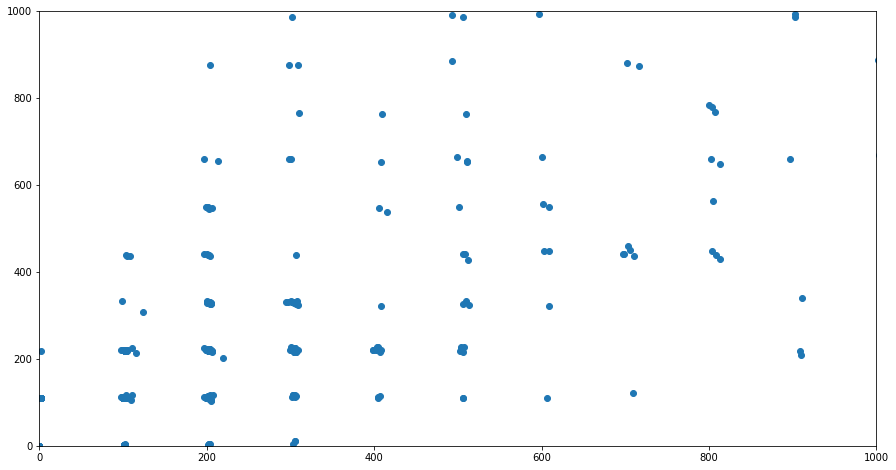

In [135]:
train_tuo = train_range[train_range['type'] == '拖网']
plt.figure(figsize=(15,8))
plt.scatter(train_tuo.x_max_x_min, train_tuo.y_max_y_min)
plt.xlim(0,1000)
plt.ylim(0,1000)

In [158]:
train_tuo[(train_tuo['x_max_x_min']<500) & (train_tuo['y_max_y_min']<500)]

,ship_ID,x_max_x_min,y_max_y_min,type
9,9,0.000000,0.000000,拖网
18,18,101.937525,110.669143,拖网
27,27,204.008594,109.260145,拖网
30,30,0.000000,0.000000,拖网
32,32,0.000000,0.000000,拖网
33,33,101.267701,111.142687,拖网
90,90,101.794560,111.596323,拖网
112,112,101.795336,2.622254,拖网
115,115,101.807394,111.650272,拖网
139,139,201.872632,111.917072,拖网


(0, 1000)

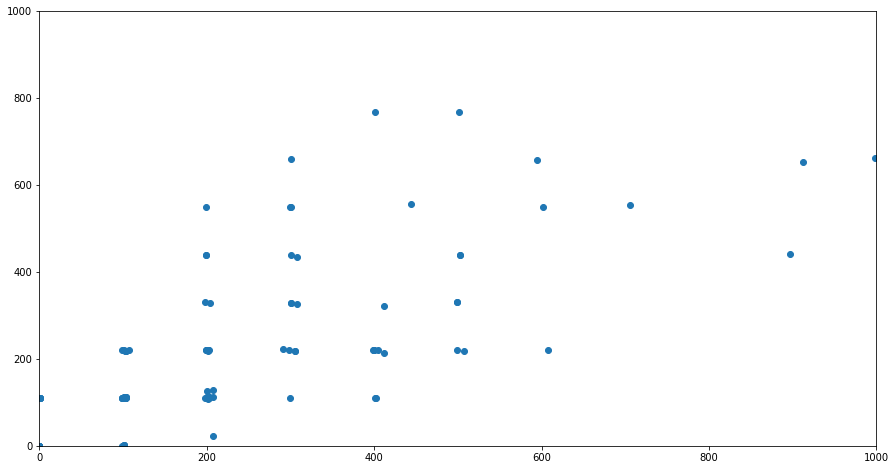

In [137]:
train_wei = train_range[train_range['type'] == '围网']
plt.figure(figsize=(15,8))
plt.scatter(train_wei.x_max_x_min, train_wei.y_max_y_min)
plt.xlim(0,1000)
plt.ylim(0,1000)

In [150]:
train_wei[(train_wei['x_max_x_min']<100) & (train_wei['y_max_y_min']<100)]

,ship_ID,x_max_x_min,y_max_y_min,type
47,47,0.000000,0.000000,围网
183,183,0.000000,0.000000,围网
408,408,0.000000,0.000000,围网
816,816,0.000000,0.000000,围网
1362,1362,0.000000,0.000000,围网
1387,1387,0.000000,0.000000,围网
1441,1441,0.000000,0.000000,围网
1489,1489,0.000000,0.000000,围网
1595,1595,0.000000,0.000000,围网
1920,1920,0.000000,0.000000,围网


In [121]:
train_ci[train_ci['x_max_x_min']>200000]

,ship_ID,x_max_x_min,y_max_y_min,type
1093,1093,242728.075264,345153.836843,刺网
1386,1386,718674.615218,339540.676480,刺网
2464,2464,457507.046909,116068.619313,刺网
2504,2504,615253.652862,890981.010166,刺网
4320,4320,754125.931636,131296.729727,刺网
4324,4324,959798.761439,155852.723206,刺网
4818,4818,623023.746822,226503.031962,刺网


In [123]:
train_1093 = train[train['ship_ID']==1093]
train_1093['delta_x'] = train_1093['x'].diff()
train_1093['delta_y'] = train_1093['y'].diff()

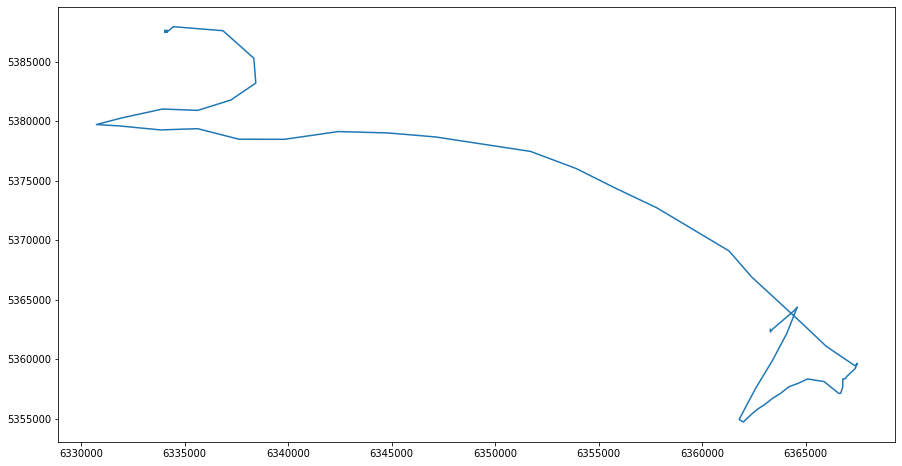

In [126]:
ttt = train_1093[train_1093['delta_x']<150000]

plt.figure(figsize=(15,8))
plt.plot(ttt.x, ttt.y)

In [133]:
train_range[(train_range['x_max_x_min']<500) & (train_range['y_max_y_min']<500)]

,ship_ID,x_max_x_min,y_max_y_min,type
9,9,0.000000,0.000000,拖网
18,18,101.937525,110.669143,拖网
27,27,204.008594,109.260145,拖网
30,30,0.000000,0.000000,拖网
32,32,0.000000,0.000000,拖网
33,33,101.267701,111.142687,拖网
35,35,202.931002,113.807920,刺网
47,47,0.000000,0.000000,围网
48,48,102.289332,110.784843,刺网
53,53,206.556285,218.293995,刺网


In [119]:
train_range['type'][(train_range['x_max_x_min']<500) & (train_range['y_max_y_min']<500)].value_counts(normalize=True)

拖网    0.487002
刺网    0.408146
围网    0.104853
Name: type, dtype: float64

In [118]:
train_range['type'][(train_range['x_max_x_min']<500) & (train_range['y_max_y_min']<500)]

9       拖网
18      拖网
27      拖网
30      拖网
32      拖网
33      拖网
35      刺网
47      围网
48      刺网
53      刺网
60      刺网
63      围网
83      刺网
87      刺网
90      拖网
112     拖网
113     刺网
115     拖网
125     刺网
131     刺网
139     拖网
156     围网
159     刺网
162     刺网
167     拖网
170     拖网
178     刺网
183     围网
189     拖网
196     拖网
        ..
6821    拖网
6824    刺网
6830    刺网
6841    刺网
6850    拖网
6853    刺网
6887    拖网
6890    刺网
6892    拖网
6893    刺网
6900    拖网
6903    围网
6904    围网
6907    拖网
6912    拖网
6915    拖网
6919    刺网
6923    围网
6927    拖网
6935    拖网
6938    拖网
6942    刺网
6947    拖网
6956    拖网
6960    拖网
6965    刺网
6973    拖网
6977    拖网
6979    刺网
6988    刺网
Name: type, Length: 1154, dtype: object

In [114]:
train_range['type'].value_counts(normalize=True)

拖网    0.623000
围网    0.231571
刺网    0.145429
Name: type, dtype: float64

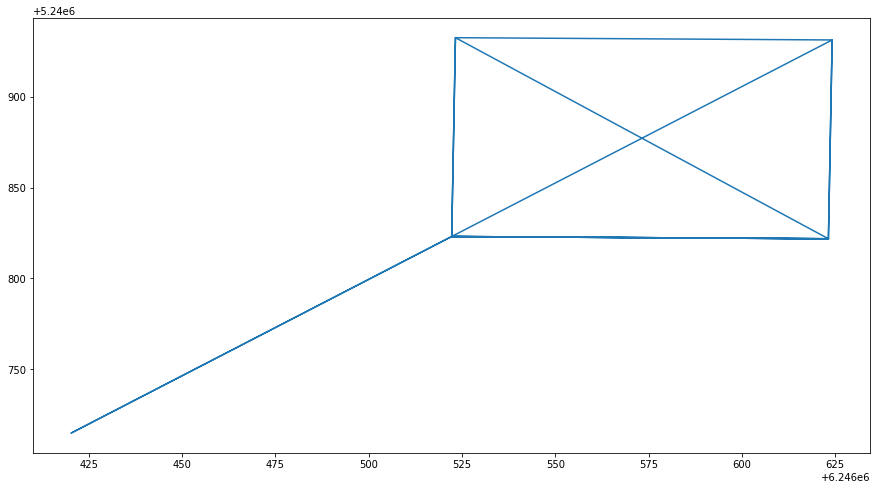

In [161]:
c = train[train['ship_ID'] == 378]

plt.figure(figsize=(15,8))
plt.plot(c.x,c.y)

In [162]:
c['delta_x'] = c['x'].diff()
c['delta_y'] = c['y'].diff()

In [164]:
c[(c['delta_x']!=0)]

,ship_ID,x,y,speed_v,direction,datetime,type,delta_time,delta_x,delta_y
402,378,6.246522e+06,5.240823e+06,0.22,301,1900-10-31 12:08:26,刺网,0,NaN,NaN
386,378,6.246623e+06,5.240822e+06,0.11,0,1900-10-31 15:08:19,刺网,10793,100.937186,-1.245586
385,378,6.246522e+06,5.240823e+06,0.32,0,1900-10-31 15:18:18,刺网,11392,-100.937186,1.245586
373,378,6.246623e+06,5.240822e+06,0.00,91,1900-10-31 17:29:03,刺网,19237,100.937186,-1.245586
372,378,6.246522e+06,5.240823e+06,0.00,0,1900-10-31 17:38:46,刺网,19820,-100.937186,1.245586
342,378,6.246623e+06,5.240822e+06,0.32,10,1900-10-31 22:59:07,刺网,39041,100.937186,-1.245586
337,378,6.246522e+06,5.240823e+06,0.00,113,1900-11-01 00:09:06,刺网,43240,-100.937186,1.245586
336,378,6.246623e+06,5.240822e+06,0.22,0,1900-11-01 00:19:06,刺网,43840,100.937186,-1.245586
331,378,6.246523e+06,5.240932e+06,0.32,0,1900-11-01 01:09:09,刺网,46843,-99.934484,110.668475
330,378,6.246624e+06,5.240931e+06,0.22,0,1900-11-01 01:29:12,刺网,48046,100.936373,-1.245576


In [92]:
train[train['ship_ID']==14].loc[350:250,:]

,ship_ID,x,y,speed_v,direction,datetime,type,delta_time
350,14,6.246627e+06,5.241260e+06,0.00,181,1900-10-28 09:22:20,拖网,33643
349,14,6.246627e+06,5.241260e+06,0.00,181,1900-10-28 09:22:38,拖网,33661
348,14,6.246627e+06,5.241260e+06,0.00,0,1900-10-28 09:32:21,拖网,34244
347,14,6.246526e+06,5.241261e+06,0.11,325,1900-10-28 09:42:22,拖网,34845
346,14,6.246627e+06,5.241260e+06,0.22,0,1900-10-28 09:52:21,拖网,35444
345,14,6.246219e+06,5.240827e+06,3.29,192,1900-10-28 10:02:42,拖网,36065
344,14,6.246218e+06,5.240717e+06,1.19,213,1900-10-28 10:12:28,拖网,36651
343,14,6.246218e+06,5.240717e+06,0.11,222,1900-10-28 10:22:38,拖网,37261
342,14,6.246218e+06,5.240717e+06,0.00,0,1900-10-28 10:32:26,拖网,37849
341,14,6.246217e+06,5.240608e+06,1.40,231,1900-10-28 10:42:26,拖网,38449


In [123]:
train['time'] = pd.to_datetime(train['time'], format='%m%d %H:%M:%S')

In [138]:
train['second'] =train['time'].dt.time

In [143]:
train.head()

,ship,x,y,v,d,time,type,second
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,拖网,11:58:19
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,拖网,11:48:19
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,拖网,11:38:19
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,拖网,11:28:19
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,拖网,11:18:19


In [159]:
p = pd.Timestamp(dt(1900,1,1,hour=0,minute=0,second=0))
p

Timestamp('1900-01-01 00:00:00')

In [161]:
train['s'] = train.time - p

In [162]:
train.head()

,ship,x,y,v,d,time,type,second,s
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,拖网,11:58:19,313 days 11:58:19
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,拖网,11:48:19,313 days 11:48:19
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,拖网,11:38:19,313 days 11:38:19
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,拖网,11:28:19,313 days 11:28:19
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,拖网,11:18:19,313 days 11:18:19


In [ ]:
t = train[train['ship'] == 1001]

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0,0].plot()

In [ ]:
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

In [91]:
random_train.ship_ID.unique()

array([1001], dtype=int64)

In [124]:
def plot_3(random_train,label):
    
    fig = plt.figure(figsize = (15,8))
    
    L1 = max(random_train.x) - min(random_train.x)
    L2 = max(random_train.y) - min(random_train.y)
    L = max([L1,L2])+10000
    
    ax1 = fig.add_axes([0.05, 0.55, 0.4, 0.4])
    ax2 = fig.add_axes([0.05, 0.05, 0.4, 0.4])
    ax3 = fig.add_axes([0.55, 0.05, 0.4, 0.9], 
                       xlim = (min(random_train.x)-10000,min(random_train.x)+L),
                       ylim = (min(random_train.y)-10000,min(random_train.y)+L)
                      )

    ax1.plot(list(random_train['delta_time']),list(random_train['speed_v']))
    ax1.set_title('speed_v')

    ax2.plot(list(random_train['delta_time']),list(random_train['direction']))
    ax2.set_title('direction')

    ax3.plot(random_train.x,random_train.y)
    
    id = random_train.ship_ID.unique()
    ax3.set_title(label+"_"+str(id))
    
    plt.savefig(f'C:/Users/f3107/Desktop/hy_data/figs/{id}.png')
    
    plt.close(fig)



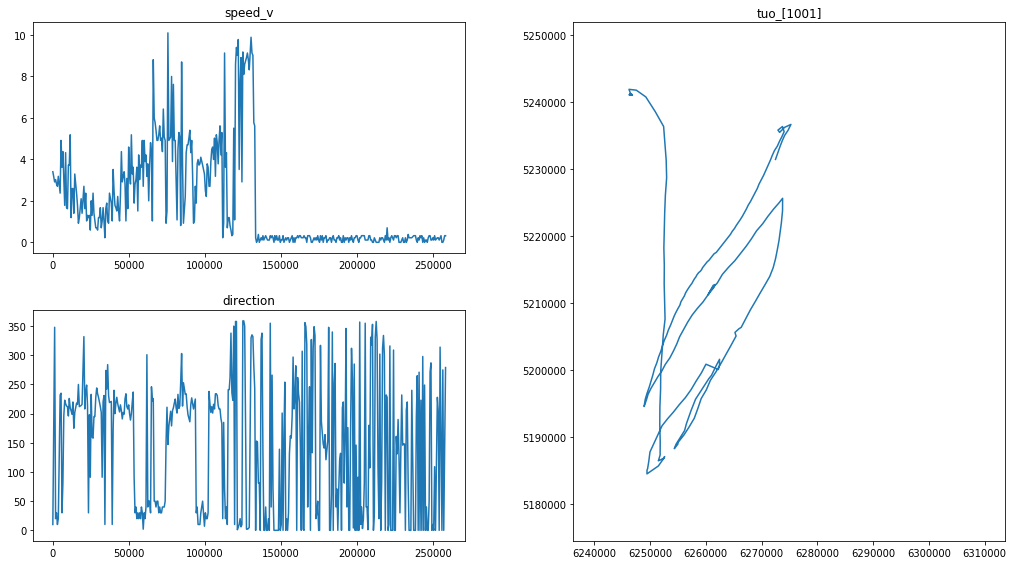

In [102]:
plot_3(random_train,'tuo')

In [104]:
train_label = train.drop_duplicates('ship_ID')

In [126]:
wei = list(train_label['ship_ID'][train_label['type'] == '围网'])

In [129]:
ci = list(train_label['ship_ID'][train_label['type'] == '刺网'])

In [132]:
tuo = list(train_label['ship_ID'][train_label['type'] == '拖网'])

In [133]:
len(tuo)

4361

In [114]:
tuo = [1,101,1018,1042,107,1064,1099,110,1112,1128,1151,117,1248,1379,157,1691,1865,2161,2397,2431]
ci = [1040,126,1415,1522,1751,1924,210,2339,2462,2577,2709,2863,2915,3867,4369,5299,604,6352,782,846]
wei = [1000,1330,1424,1558,1628,1805,2144,2333,2517,2755,3011,3375,4,42,49,4899,4639,4590,438,414]

In [134]:
for i in tuo:
    random_train = train[train['ship_ID'] == i]
    plot_3(random_train,'tuo')
    

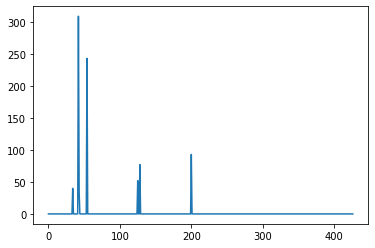

In [53]:
plt.plot(t['d'])

In [45]:
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

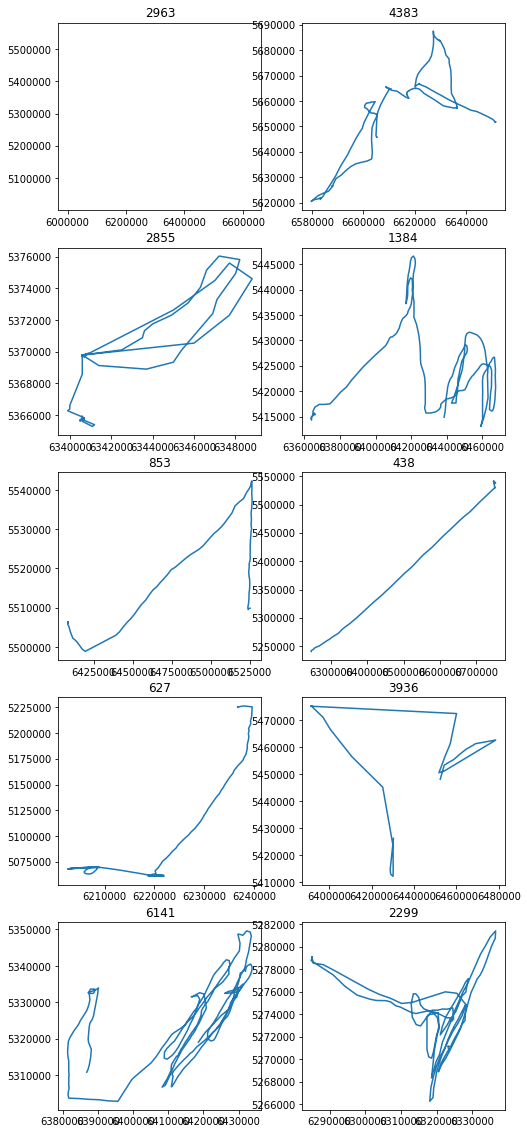

In [46]:
show_path('围网')

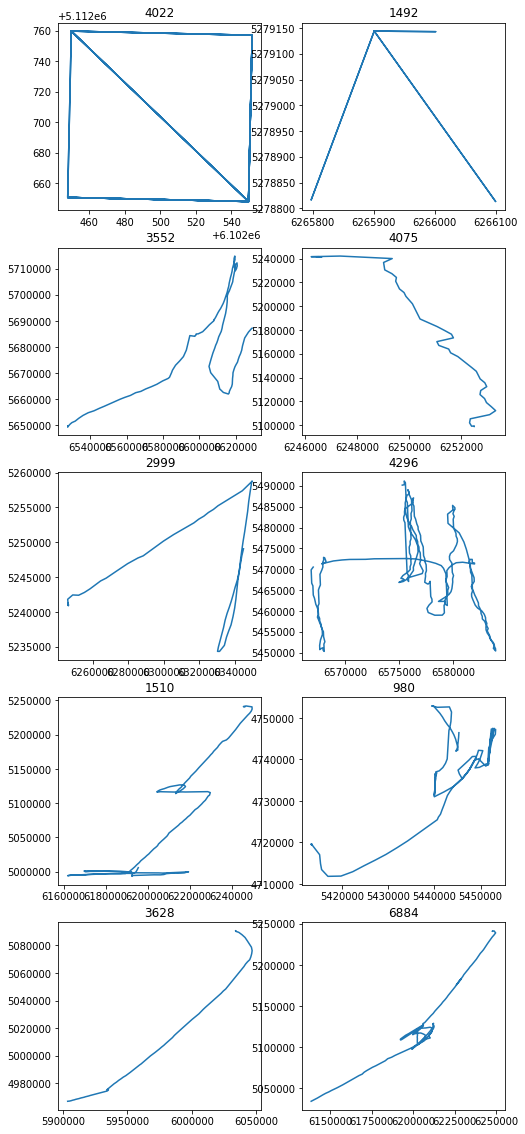

In [47]:

show_path('拖网')

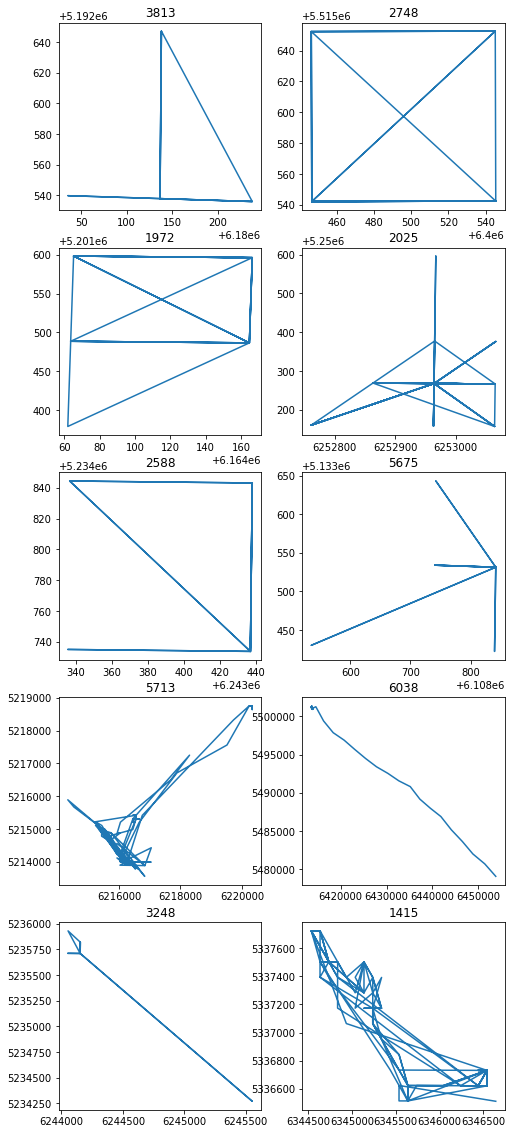

In [48]:
show_path('刺网')